## Plotting Functions

In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from fff.utils.func import compute_jacobian


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INFO: Using pytorch backend
2025-10-15 18:02:55.091915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


In [2]:
@torch.no_grad()
def get_nll_dataset(fiber_model, subject_model, test_loader, sigmas=[0.0, 0.001, 0.01, 0.1], max_batches=10):
    fiber_model.to(device)
    subject_model.to(device)

    nlls_sigma = {}
    for sigma in tqdm(sigmas, desc="Computing NLL for all sigmas..."):
        nlls = []
        for i, x in enumerate(test_loader):
            if i>=max_batches:
                break
            x = x[0].to(device)
            c = subject_model.encode(x, torch.empty(x.shape[0],device=device))
            c_perturbed = c + torch.randn_like(c)*sigma
            with torch.enable_grad():
                z, Jacs = compute_jacobian(x.reshape(-1, 3*28*28), fiber_model.encode, c_perturbed, chunk_size=None)
            Jacs = Jacs.squeeze()
            log_jacs_complete = torch.bmm(Jacs, Jacs.permute((0,-1,-2))).logdet()/2
            i_invalid = torch.logical_or(torch.isinf(log_jacs_complete), torch.isnan(log_jacs_complete))
            nll = torch.mean(z**2, dim=1)/2 - log_jacs_complete/z.shape[1]
            nlls.append(nll[~i_invalid].cpu())
        nlls_sigma[sigma] = torch.cat(nlls, dim=0)
    return nlls_sigma

def get_fiber_loss(fiber_model, subject_model, test_loader, max_batches=10):
    fiber_model.to(device)
    subject_model.to(device)
    fiber_losses = []
    for i, x in enumerate(test_loader):
        if i>=max_batches:
            break
        x = x[0].to(device)
        c = subject_model.encode(x, torch.empty(x.shape[0],device=device))
        samples = fiber_model.sample(c, N_samples_per_c=1).squeeze(1)
        c_sampled = subject_model.encode(samples, torch.empty(samples.shape[0], device=device))
        fiber_loss = torch.sqrt(torch.sum((c-c_sampled)**2, dim=-1)/c.shape[1])
        i_invalid = torch.logical_or(torch.isinf(fiber_loss), torch.isnan(fiber_loss))
        fiber_losses.append(fiber_loss[~i_invalid].cpu())
    return torch.cat(fiber_losses, dim=0)

In [3]:
def plot_ll(fiber_model, subject_model, test_loader, sigmas=[0.0, 0.001, 0.01, 0.1], max_batches=10, model_name="Fiber model", color="C0"):
    # compute and plot the nll
    nlls = get_nll_dataset(fiber_model, subject_model, test_loader, sigmas=sigmas, max_batches=max_batches)
    plt.figure(figsize=(8,6))
    lls_means = [- nll.mean().item() for nll in nlls.values()]
    plt.plot(sigmas, lls_means, marker='o', label=model_name, color=color)
    plt.xscale('log')
    plt.xlabel(r'$\sigma$')
    plt.ylabel('log-likelihood')
    plt.title('Fiber quality')
    plt.grid(True)

def plot_fiber_loss(fiber_model, subject_model, test_loader, max_batches=10, model_name="Fiber model", color="C0"):
    fiber_losses = get_fiber_loss(fiber_model, subject_model, test_loader, max_batches=max_batches)
    plt.figure(figsize=(8,6))
    plt.hist(fiber_losses.numpy(), bins=50, density=True, alpha=0.5, color=color)
    plt.xlabel(r'$\sqrt{\frac{(c_{true}-c_{rec})^2}{dim_c}}$')
    plt.ylabel('Density')
    plt.title(f'Fiber loss distribution for {model_name}')
    plt.grid(True)

## Load Models and datasets

In [4]:
import torch
import fff
import lightning_trainable
import h5py

In [5]:
torch.set_grad_enabled(False)

def load_model(name):
    try:
        checkpoint = lightning_trainable.utils.find_checkpoint(root=f"color_logs/{name}", version=0, epoch="best")
    except:
        checkpoint = lightning_trainable.utils.find_checkpoint(root=f"color_logs/{name}", version=0, epoch="last")
    ckpt = torch.load(checkpoint)
    hparams = ckpt["hyper_parameters"]
    hparams["cond_dim"] = 0
    hparams["data_set"]["root"] = '/home/armand/PhD/color_mnist_eval/cc_mnist'
    hparams["data_set"]["subject_model_path"] = '/home/armand/PhD/color_mnist_eval/cc_mnist/subject_model/checkpoints/299_fixed.ckpt'
    hparams["lossless_ae"] = {"model_spec": hparams["lossless_ae"]}
    hparams["load_lossless_ae_path"] = '/home/armand/PhD/color_mnist_eval/color_logs/Lossless_VAE/checkpoints/last_fixed.ckpt'
    model = fff.fiber_model.FiberModel(hparams)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    model.to(device)
    return model, model.subject_model

def load_all_models(names):
    model_list = {}
    for name in names:
        fiber_model, subject_model = load_model(name)
        model_list[name] = {'fiber_model': fiber_model, 'subject_model': subject_model}
    return model_list

In [6]:
def get_dataloader(batch_size=256):
    with h5py.File('/home/armand/PhD/color_mnist_eval/cc_mnist/data.h5', 'r') as f:
        x_val = torch.from_numpy(f['test_images'][:]).to(device) # TODO: Retrain everything again with a validation set this time...
        x_test = torch.from_numpy(f['test_images'][:]).to(device)
    val_set = torch.utils.data.TensorDataset(x_val)
    test_set = torch.utils.data.TensorDataset(x_test)
    return torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False), torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

## Plotting

In [7]:
models_to_evaluate = [
    "250_nf",
    "100_dnf",
]

all_models = load_all_models(models_to_evaluate)

/tmp/ipykernel_308575/2602949427.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint)


(240000, 3, 28, 28)
loading subject_model


/home/armand/miniconda3/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locati

torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96


/home/armand/PhD/FFF_fiberlearning/fff/fiber_model.py:230: UserWarning: Overwriting model_spec from config with loaded model!
  warn("Overwriting model_spec from config with loaded model!")


Overwriting lossless ae model spec with pretrained model
cond_dim:  0
output_dim:  108
Loading lossless_ae checkpoint from:  /home/armand/PhD/color_mnist_eval/color_logs/Lossless_VAE/checkpoints/last_fixed.ckpt
54
(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96
Overwriting lossless ae model spec with pretrained model
cond_dim:  0
output_dim:  108
Loading lossless_ae checkpoint from:  /home/armand/PhD/color_mnist_eval/color_logs/Lossless_VAE/checkpoints/last_fixed.ckpt


In [8]:
dataloader, _ = get_dataloader(batch_size=256)

Computing NLL for all sigmas...:   0%|          | 0/4 [00:00<?, ?it/s]

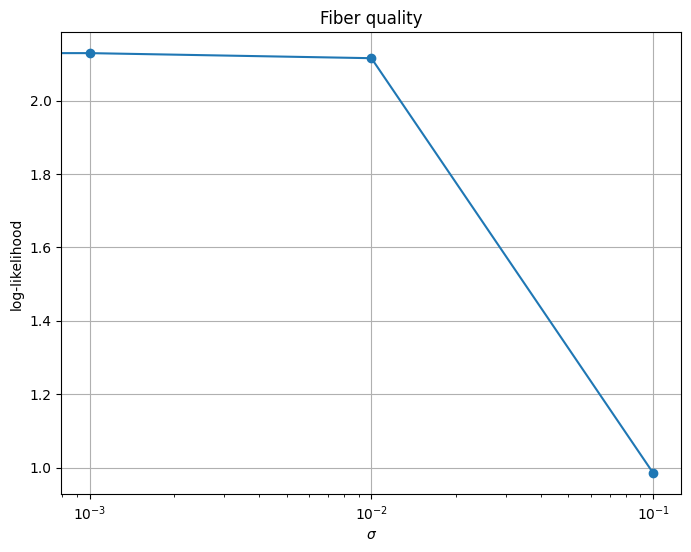

In [9]:
plot_ll(all_models["250_nf"]['fiber_model'], all_models["250_nf"]['subject_model'], dataloader, model_name="250_nf", color="C0")

In [7]:
from torch.distributions import Normal, Uniform
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily

weights = torch.tensor([0.6, 0.35, 0.05]).to(device)
centers = torch.tensor([0.7, 0.5, 0.1]).to(device)
stddevs = torch.tensor([0.08, 0.015, 0.02]).to(device)

def Decolorize(x_colored):
    def detect_colors(x_data):
        background_colors = torch.mean(x_data[:,:,:,0],-1)
        return background_colors
    x_c = x_colored.reshape(-1,3,28,28)
    c = detect_colors(x_c)
    c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_dc = (x_c-c_image) / ((c_image+0.5)%1 - c_image)
    return x_dc.abs(), c

def get_background_gmm(weights, centers, stddevs):
    mix = Categorical(weights)
    comp = Normal(centers, stddevs)
    gmm = MixtureSameFamily(mix, comp)
    return gmm

def get_background_uniform():
    dist = Uniform(torch.zeros(1, device=device), torch.ones(1, device=device))
    return dist

def log_likelihood_colored_image(x, color_dist, sigma_condition, subject_model, c_target):
    c_pred = subject_model.encode(x, torch.empty(x.shape[0], device=device))
    ll_condition = Normal(c_target, sigma_condition).log_prob(c_pred).sum(dim=-1)
    x_dc, c = Decolorize(x)
    ll_background = color_dist.log_prob(c).sum(dim=-1)
    return ll_condition + ll_background

def get_nll_combination(color_dist, sigma_condition, subject_model, test_loader, sigmas=[0.0, 0.0001, 0.001, 0.01], max_batches=10):
    # compute and plot the nll
    nlls_sigmas = {}
    for sigma in sigmas:
        nlls = []
        for i, x in enumerate(test_loader):
            if i>=max_batches:
                break
            x = x[0].to(device)
            c = subject_model.encode(x, torch.empty(x.shape[0],device=device))
            c_perturbed = c + torch.randn_like(c)*sigma
            ll = log_likelihood_colored_image(x, color_dist, sigma_condition, subject_model, c_perturbed)
            nll = - ll
            i_invalid = torch.logical_or(torch.isinf(nll), torch.isnan(nll))
            if i_invalid.any():
                print(f"Warning: Invalid NLL values encountered for sigma={sigma} in batch {i}. These will be ignored.")
            nlls.append(nll[~i_invalid].cpu())
        nlls_sigmas[sigma] = torch.cat(nlls, dim=0)
    return nlls_sigmas
    
def plot_log_likelihood_toy_model(nlls_dicts):
    plt.figure(figsize=(8,6))


    for model_name, nlls_sigmas in nlls_dicts.items():
        lls_means = [- nll.mean().item() for nll in nlls_sigmas.values()]
        plt.plot(nlls_sigmas.keys(), lls_means, marker='o', label=model_name)

    # plt.xscale('symlog', linthresh=0.000015)
    plt.xlabel(r'$\sigma$')
    plt.ylabel('log-likelihood (unnormalized)')
    plt.title('Fiber quality')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

def plot_color_distributions(settings_dict, test_loader):
    colors = []
    for i, x in enumerate(test_loader):
        _, c = Decolorize(x[0].to(device))
        colors.append(c.cpu())
    colors = torch.cat(colors, dim=0)
    plt.figure(figsize=(12,12))
    for i, (model_name, settings) in enumerate(settings_dict.items()):
        plt.subplot(len(nlls_dicts.keys())//2,2,i+1)
        plt.hist(colors.cpu().numpy(), bins=50, density=True, alpha=0.5)
        xx = torch.linspace(0.0, 1.0, 100).to(device)
        plt.plot(xx.cpu(), settings["color_dist"].log_prob(xx).exp().cpu().numpy())
        plt.title(model_name)
    plt.show()
    plt.close()                             

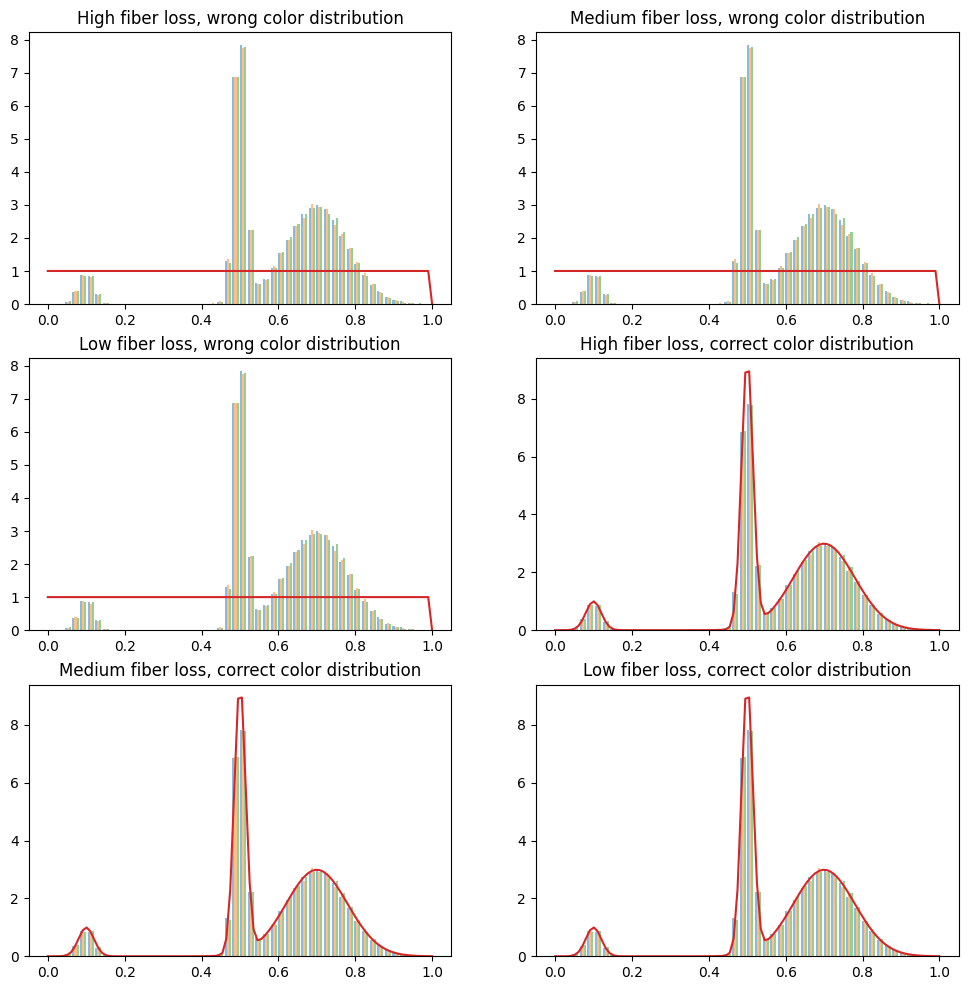

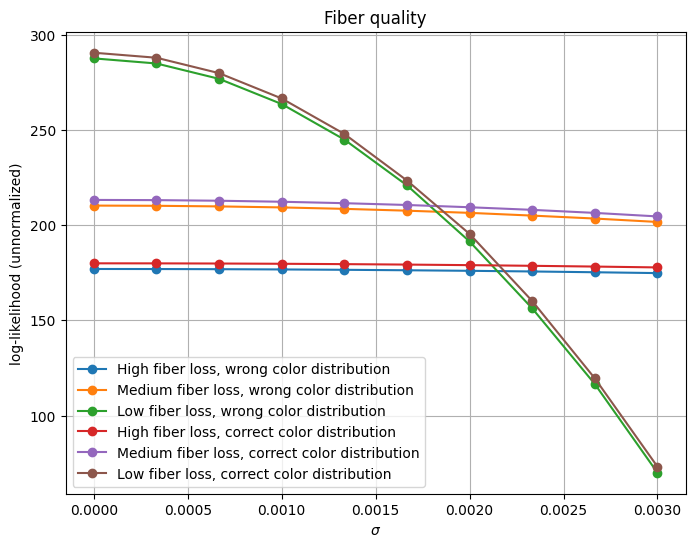

In [70]:
settings_dict = {
    "High fiber loss, wrong color distribution": {"color_dist": get_background_uniform(), "sigma_condition": 0.01},
    "Medium fiber loss, wrong color distribution": {"color_dist": get_background_uniform(), "sigma_condition": 0.005},
    "Low fiber loss, wrong color distribution": {"color_dist": get_background_uniform(), "sigma_condition": 0.001},
    "High fiber loss, correct color distribution": {"color_dist": get_background_gmm(weights, centers, stddevs), "sigma_condition": 0.01},
    "Medium fiber loss, correct color distribution": {"color_dist": get_background_gmm(weights, centers, stddevs), "sigma_condition": 0.005},
    "Low fiber loss, correct color distribution": {"color_dist": get_background_gmm(weights, centers, stddevs), "sigma_condition": 0.001},
}

nlls_dicts = {}
for model_name, settings in settings_dict.items():
    nlls_dicts[model_name] = get_nll_combination(settings["color_dist"], 
                                                 settings["sigma_condition"], 
                                                 all_models["250_nf"]['subject_model'], 
                                                 dataloader, 
                                                 sigmas=torch.linspace(0, 0.003, 10), 
                                                 max_batches=10)

plot_color_distributions(settings_dict, dataloader)
plot_log_likelihood_toy_model(nlls_dicts)

# Combine NDTM samples

In [4]:
import torch
import os

ndtm_0 = ("250_ndtm_0", [])
ndtm_1 = ("250_ndtm_1", [])
ndtm_2 = ("250_ndtm_2", [])
ndtm_3 = ("250_ndtm_3", [])

ndtm_correlated_0 = ("250_ndtm_correlated_0", [])
ndtm_correlated_1 = ("250_ndtm_correlated_1", [])
ndtm_correlated_2 = ("250_ndtm_correlated_2", [])
ndtm_correlated_3 = ("250_ndtm_correlated_3", [])

for fname in os.listdir("."):
    if not (fname.startswith("sampled_colormnist") and fname.endswith(".pt")):
        continue
    if "uncorrelated" in fname:
        if "w_terminal=0.25" in fname:
            list_to_use = ndtm_0
        elif "w_terminal=0.5" in fname:
            list_to_use = ndtm_1
        elif "w_terminal=1.0" in fname:
            list_to_use = ndtm_2
        elif "w_terminal=2.0" in fname:
            list_to_use = ndtm_3
        else:
            raise(RuntimeError(f"Cannot parse filename {fname}"))
    else:
        if "w_terminal=0.25" in fname:
            list_to_use = ndtm_correlated_0
        elif "w_terminal=0.5" in fname:
            list_to_use = ndtm_correlated_1
        elif "w_terminal=1.0" in fname:
            list_to_use = ndtm_correlated_2
        elif "w_terminal=2.0" in fname:
            list_to_use = ndtm_correlated_3
        else:
            raise(RuntimeError(f"Cannot parse filename {fname}"))
    list_to_use[1].append(torch.load(fname))


for list_to_use in [ndtm_0, ndtm_1, ndtm_2, ndtm_3, ndtm_correlated_0, ndtm_correlated_1, ndtm_correlated_2, ndtm_correlated_3]:
    combined_dict = {"samples": [], "originals": [], "sample_embeddings": [], "original_embeddings": []}
    for res_dict in list_to_use[1]:
        combined_dict["samples"].append(res_dict["invariances"])
        combined_dict["originals"].append(res_dict["originals"])
        combined_dict["sample_embeddings"].append(res_dict["invariances_embeddings"])
        combined_dict["original_embeddings"].append(res_dict["original_embeddings"])
    for key in combined_dict.keys():
        if len(combined_dict[key]):
            combined_dict[key] = torch.cat(combined_dict[key], dim=0)
    save_name = os.path.join("col_mnist/col_mnist_plots", list_to_use[0], "samples.pt")
    torch.save(combined_dict, save_name)

# Draw samples of all models

In [3]:
import h5py
import numpy as np
from scipy.special import kl_div, rel_entr
import torch
import lightning_trainable
import os
import fff
import matplotlib.pyplot as plt
from fff.evaluate.fid import compute_fid_openai_tf as compute_fid

device = "cuda" if torch.cuda.is_available() else "cpu"

log_folder = "/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/color_logs"
plot_folder = "/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/col_mnist/col_mnist_plots/"

def Decolorize(x_colored):
    def detect_colors(x_data):
        background_colors = torch.mean(x_data[:,:,:,0],-1)
        return background_colors
    x_c = x_colored.reshape(-1,3,28,28)
    c = detect_colors(x_c)
    c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_dc = (x_c-c_image) / ((c_image+0.5)%1 - c_image)
    return x_dc.abs(), c

def normal(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma
def gaussian_mix_dense(x):
    return 0.6 * normal(x, 0.7, 0.08) + 0.35 * normal(x, 0.5, 0.015) + 0.05 * normal(x, 0.1, 0.02)


class SubjectModelInterface:
    def __init__(self, subject_model):
        self.subject_model = subject_model

    def __call__(self, x):
        return self.subject_model.encode(x, torch.empty((x.shape[0], 1), device=x.device))

def load_model(name):
    if "ndtm" in name:
        name = "250_nf"
    try:
        checkpoint = lightning_trainable.utils.find_checkpoint(root=f"{log_folder}/{name}", version=0, epoch="best")
    except:
        checkpoint = lightning_trainable.utils.find_checkpoint(root=f"{log_folder}/{name}", version=0, epoch="last")
    ckpt = torch.load(checkpoint, weights_only=False)
    hparams = ckpt["hyper_parameters"]
    hparams["cond_dim"] = 0
    hparams["data_set"]["root"] = '/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/cc_mnist'
    hparams["data_set"]["subject_model_path"] = '/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/cc_mnist/subject_model/checkpoints/299_fixed.ckpt'
    hparams["lossless_ae"] = {"model_spec": hparams["lossless_ae"]}
    hparams["load_lossless_ae_path"] = '/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/color_logs/Lossless_VAE/checkpoints/last_fixed.ckpt'
    if "FlowMatching" in hparams["density_model"][0]["name"]:
        hparams["density_model"][0]["interpolation_schedule"] = hparams["density_model"][0].pop("interpolation")
        hparams["density_model"][0].pop("sigma")
        hparams["density_model"][0]["network_hparams"] = {"layers_spec": hparams["density_model"][0].pop("layers_spec")}
    model = fff.fiber_model.FiberModel(hparams)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    model.to(device)
    return model

def save_model_samples(samples, originals, sample_embeddings, original_embeddings, name):
    save_path = os.path.join(plot_folder, name)
    os.makedirs(save_path, exist_ok=True)
    torch.save({
        "samples": samples,
        "originals": originals,
        "sample_embeddings": sample_embeddings,
        "original_embeddings": original_embeddings
    }, os.path.join(save_path, "samples.pt"))

def save_model_stats(fl_stats, kl_stats, w1_stats, dev_stats, fid_stats, name):
    save_path = os.path.join(plot_folder, name)
    os.makedirs(save_path, exist_ok=True)
    torch.save({
        "fl_stats": fl_stats,
        "kl_stats": kl_stats,
        "w1_stats": w1_stats,
        "dev_stats": dev_stats,
        "fid_stats": fid_stats,
    }, os.path.join(save_path, "stats.pt"))
    
def load_model_samples(name):
    load_path = os.path.join(plot_folder, name, "samples.pt")
    samples_dict = torch.load(load_path)
    return samples_dict["samples"], samples_dict["originals"], samples_dict["sample_embeddings"], samples_dict["original_embeddings"], 


def load_model_stats(name):
    load_path = os.path.join(plot_folder, name, "stats.pt")
    stats_dict = torch.load(load_path, weights_only=False)
    return stats_dict["fl_stats"], stats_dict["kl_stats"], stats_dict["w1_stats"], stats_dict["dev_stats"], stats_dict["fid_stats"],

@torch.no_grad()
def evaluate_model(model_name, dataset=None, samples_per_image=10, batch_size=512, save=True):
    print(f"Evaluating model {model_name}")
    fiber_model = load_model(model_name)
    subject_model = SubjectModelInterface(fiber_model.subject_model)
    
    if dataset is not None:
        if not isinstance(dataset, torch.utils.data.TensorDataset):
            dataset = torch.utils.data.TensorDataset(dataset)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    try:
        samples, originals, sample_embeddings, original_embeddings = load_model_samples(model_name)
        if dataset is not None:
            if torch.mean((dataset[:][0] - originals)**2) > 1.e-6:
                raise ValueError("Dataset not identical to precomputed dataset")
            else:
                print("Using precomputed dataset")
    except Exception as e:
        # print(e)
        assert dataset is not None, "If no precomputed samples are available, dataset has to be passed"
    
        samples = []
        originals = []
        sample_embeddings = []
        original_embeddings = []
        
        for n_batch, batch in enumerate(dataloader):
            x = batch[0].to(device).float()
            test_image_embedding = subject_model(x)

            samples_image = []
            embeddings_image = []
            for i in range(samples_per_image):
                samples_image.append(fiber_model.sample(torch.Size([x.shape[0]]), test_image_embedding.to(device)).reshape(x.shape[0], 3, 28, 28))
                embeddings_image.append(subject_model(samples_image[-1]))
            samples.append(torch.stack(samples_image, dim=1))
            sample_embeddings.append(torch.stack(embeddings_image, dim=1))
            originals.append(x)
            original_embeddings.append(test_image_embedding)
            
        samples = torch.cat(samples, dim=0)
        sample_embeddings = torch.cat(sample_embeddings, dim=0)
        originals = torch.cat(originals, dim=0)
        original_embeddings = torch.cat(original_embeddings, dim=0)
        
        if save:
            save_model_samples(samples, originals, sample_embeddings, original_embeddings, model_name)
    
    fl_stats = compute_fiber_loss_model(originals.to(device), 
                                        samples.to(device), 
                                        original_embeddings.to(device), 
                                        sample_embeddings.to(device), 
                                        subject_model)
    kl_stats, w1_stats, dev_stats = compute_kl_w1_and_deviation(samples.permute(1, 0, 2, 3, 4))
    fid_stats = compute_fid_with_std(originals.to(device), samples.to(device))
    if save:
        save_model_stats(fl_stats, kl_stats, w1_stats, dev_stats, fid_stats, model_name)
    return fl_stats, kl_stats, w1_stats, dev_stats, fid_stats
    
@torch.no_grad()
def compute_fiber_loss_model(originals, samples, original_embeddings, sample_embeddings, subject_model, batch_size=2048):
    N=None
    n_rows=5
    fiber_loss = []
    
    dataset = torch.utils.data.TensorDataset(originals, samples, original_embeddings, sample_embeddings)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    print("Computing Fiber Loss...")
    
    for sam_i in range(samples.shape[1]):
        fiber_loss_sami = []

        for i, batch in enumerate(dataloader):
            test_samples, x_sampled, test_c, xc = batch
            x_sampled, xc = x_sampled[:,sam_i], xc[:,sam_i]
            if i == 0 and sam_i == 0:
                # sanity check
                xc_recomputed = subject_model(x_sampled)
                assert torch.sqrt(torch.mean((xc-xc_recomputed)**2,-1)).mean() < 1.e-4, f"Fiber loss between identical samples is {torch.sqrt(torch.sum((xc-xc_recomputed)**2,-1)/float(xc.shape[-1])).mean()}"
            

            fiber_loss_sami.append(torch.sqrt(torch.sum((xc-test_c)**2,-1)/float(xc.shape[-1])))
        fiber_loss.append(torch.cat(fiber_loss_sami,0).cpu())
    
    fl_mean, fl_std = torch.cat(fiber_loss, dim=0).mean(), torch.cat(fiber_loss, dim=0).std() 
    print("fiber_loss mean is: ", fl_mean, " +- ", fl_std)
    
    return (fl_mean, fl_std)

@torch.no_grad()
def compute_fid_with_std(originals, samples):
    print("Computing FID...")
    fids = []
    for sam_i in range(samples.shape[1]):
        fid = compute_fid(originals, samples[:,sam_i])[1]
        fids.append(fid)
    fid_mean, fid_std = np.mean(fids), np.std(fids)
    print("fid mean is: ", fid_mean, " +- ", fid_std)
    
    return (fid_mean, fid_std)

def compute_kl_w1_and_deviation(sample_list, n_bins=100):
    print("Computing KL Divergence...")
    kls_r, kls_g, kls_b = [], [], []
    w1s_r, w1s_g, w1s_b = [], [], []
    dev = []
    for samples in sample_list:
        x_dc, colors = Decolorize(samples)
        max_pix = torch.max(x_dc.mean(1).reshape(-1,28*28), -1)[0].cpu()
        dev.append(torch.abs(max_pix - 1).mean().numpy())

        kls_c, w1s_c = [], []
        for c in range(3):
            H, bins = np.histogram(colors[:, c].cpu(), bins=n_bins, range=[0,1], density=True)
            bin_width = bins[1] - bins[0]
            mids = bins[:-1] + bin_width / 2

            # Discretized probabilities
            p = H * bin_width
            q = gaussian_mix_dense(mids) * bin_width
            p /= p.sum()
            q /= q.sum()

            # KL divergence
            kl_per_bin = rel_entr(p, q)
            kl_per_bin = kl_per_bin[~np.logical_or(np.isnan(kl_per_bin), np.isinf(kl_per_bin))]
            kl = np.sum(kl_per_bin)
            kls_c.append(kl)

            # Wasserstein-1 distance
            C_p = np.cumsum(p)
            C_q = np.cumsum(q)
            tv_per_bin = np.abs(C_p - C_q)
            tv_per_bin = tv_per_bin[~np.logical_or(np.isnan(tv_per_bin), np.isinf(tv_per_bin))]
            w1 = np.sum(tv_per_bin) * bin_width
            w1s_c.append(w1)

        kls_r.append(kls_c[0]); kls_g.append(kls_c[1]); kls_b.append(kls_c[2])
        w1s_r.append(w1s_c[0]); w1s_g.append(w1s_c[1]); w1s_b.append(w1s_c[2])

    # Aggregate statistics
    def summarize(values):
        mean = np.mean(values)
        std = np.std(values)
        return mean, std

    kl_means = [summarize(x) for x in [kls_r, kls_g, kls_b]]
    w1_means = [summarize(x) for x in [w1s_r, w1s_g, w1s_b]]
    dev_mean, dev_std = summarize(dev)

    print("Red KL mean is: ", kl_means[0][0], " +- ", kl_means[0][1])
    print("Green KL mean is: ", kl_means[1][0], " +- ", kl_means[1][1])
    print("Blue KL mean is: ", kl_means[2][0], " +- ", kl_means[2][1])

    return kl_means, w1_means, (dev_mean, dev_std)


/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend
2026-01-10 18:56:25.755594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model_names = {
    "fff": ["250_fff", "250_fff_0", "250_fff_1", "250_fff_2"],
    "f3f": ["250_f3f", "250_f3f_0", "250_f3f_1", "250_f3f_2"],
    "nf": ["250_nf", "250_nf_0", "250_nf_1", "250_nf_2"],
    "dnf": ["100_dnf", "100_dnf_0", "100_dnf_1", "100_dnf_2"],
    "mlf": ["100_mlf", "250_mlf_0", "250_mlf_1"],
    "diff": ["1000_diff"],
    "cfm": ["250_cfm"],
    # "ndtm": ["250_ndtm_0", "250_ndtm_1", "250_ndtm_2", "250_ndtm_3"],
    # "ndtm_correlated": ["250_ndtm_correlated_0", "250_ndtm_correlated_1", "250_ndtm_correlated_2", "250_ndtm_correlated_3"],
}

with h5py.File('/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/cc_mnist/data.h5', 'r') as f:
    test_data = torch.from_numpy(f['test_images'][:])

for model_class in model_names.keys():
    for model_name in model_names[model_class]:
        evaluate_model(model_name, dataset=None)

Evaluating model 250_fff
(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96
Overwriting lossless ae model spec with pretrained model
cond_dim:  0
output_dim:  108
Loading lossless_ae checkpoint from:  /home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/color_logs/Lossless_VAE/checkpoints/last_fixed.ckpt
cond_dim:  48
output_dim:  54
Computing Fiber Loss...
fiber_loss mean is:  tensor(0.2583)  +-  tensor(0.1243)
Computing KL Divergence...
Red KL mean is:  0.07169968625356905  +-  0.003965955949630429
Green KL mean is:  0.19166057100568512  +-  0.004547184816992016
Blue KL mean is:  0.12510611686951215  +-  0.005077358261948435
Computing FID...


I0000 00:00:1767971611.875199   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:41<00:00, 15.02it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.6958751678466797
FID: 9.436591596850292
sFID: 4.322075952969101
Precision: 0.6838
Recall: 0.6357



I0000 00:00:1767971769.594592   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:41<00:00, 15.01it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.6990809440612793
FID: 9.414269903784344
sFID: 4.36995779941094
Precision: 0.685525
Recall: 0.633475



I0000 00:00:1767971927.362216   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:41<00:00, 15.02it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.7260966300964355
FID: 9.23271851253341
sFID: 4.328967194010261
Precision: 0.68665
Recall: 0.625075



I0000 00:00:1767972082.620693   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:41<00:00, 15.02it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.7087252140045166
FID: 9.356482366664011
sFID: 4.326244722141325
Precision: 0.687975
Recall: 0.6317



I0000 00:00:1767972240.421951   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:41<00:00, 15.02it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.7036006450653076
FID: 9.41353951813332
sFID: 4.383198644108404
Precision: 0.68485
Recall: 0.6373



I0000 00:00:1767972395.922021   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.76it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.704342842102051
FID: 9.348958360867982
sFID: 4.312432070795808
Precision: 0.6867
Recall: 0.6318



I0000 00:00:1767972563.779345   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.75it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.710066795349121
FID: 9.448672344492309
sFID: 4.345095040086505
Precision: 0.686225
Recall: 0.632975



I0000 00:00:1767972719.094115   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.77it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.7118496894836426
FID: 9.331798954755783
sFID: 4.353042259028996
Precision: 0.688575
Recall: 0.63685



I0000 00:00:1767972874.703692   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.55it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.7094039916992188
FID: 9.325489450188911
sFID: 4.339062941523537
Precision: 0.682125
Recall: 0.631225



I0000 00:00:1767973036.196144   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.74it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.702340841293335
FID: 9.354384321261193
sFID: 4.334287677101031
Precision: 0.6858
Recall: 0.635525

fid mean is:  9.366290532953155  +-  0.06123539273634687
Evaluating model 250_fff_0
(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96
Overwriting lossless ae model spec with pretrained model
cond_dim:  0
output_dim:  108
Loading lossless_ae checkpoint from:  /home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/color_logs/Lossless_VAE/checkpoints/last_fixed.ckpt
cond_dim:  48
output_dim:  54
Computing Fiber Loss...
fiber_loss mean is:  tensor(0.2345)  +-  tensor(0.0935)
Computing KL Divergence...
Red KL mean is:  0.11551414346171578  +-  0.004088505860312153
Gree

I0000 00:00:1767973215.685973   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.77it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.4191031455993652
FID: 18.535152632480703
sFID: 5.70295547776783
Precision: 0.71515
Recall: 0.628675



I0000 00:00:1767973372.770780   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.77it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.4182472229003906
FID: 18.65199017241727
sFID: 5.735366530607905
Precision: 0.7089
Recall: 0.632625



I0000 00:00:1767973529.823498   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.76it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.418329954147339
FID: 18.522657350707277
sFID: 5.699685931370368
Precision: 0.71315
Recall: 0.62555



I0000 00:00:1767973691.838154   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.77it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.4151079654693604
FID: 18.774986759979384
sFID: 5.742359595186031
Precision: 0.714775
Recall: 0.622675



I0000 00:00:1767973848.408923   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.77it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.437218427658081
FID: 18.41756520258943
sFID: 5.730521866690083
Precision: 0.714825
Recall: 0.62885



I0000 00:00:1767974004.453505   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.76it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.4172322750091553
FID: 18.531575553566398
sFID: 5.682979201999217
Precision: 0.713625
Recall: 0.63195



I0000 00:00:1767974162.321495   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.73it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.4269859790802
FID: 18.388034848018407
sFID: 5.6801957553827265
Precision: 0.71485
Recall: 0.628875



I0000 00:00:1767974319.501152   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.74it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.427907705307007
FID: 18.540169398993527
sFID: 5.675232162000611
Precision: 0.715
Recall: 0.62575



I0000 00:00:1767974485.064870   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.74it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.41780948638916
FID: 18.605930360093026
sFID: 5.715996707682109
Precision: 0.710625
Recall: 0.631675



I0000 00:00:1767974644.781408   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.75it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.412822723388672
FID: 18.75887922052658
sFID: 5.718303117065943
Precision: 0.713975
Recall: 0.628825

fid mean is:  18.5726941499372  +-  0.1215752354415415
Evaluating model 250_fff_1
(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96
Overwriting lossless ae model spec with pretrained model
cond_dim:  0
output_dim:  108
Loading lossless_ae checkpoint from:  /home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/color_logs/Lossless_VAE/checkpoints/last_fixed.ckpt
cond_dim:  48
output_dim:  54
Computing Fiber Loss...
fiber_loss mean is:  tensor(0.1833)  +-  tensor(0.0641)
Computing KL Divergence...
Red KL mean is:  0.26997675368394203  +-  0.004035132763416766
Gree

I0000 00:00:1767974823.358202   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.77it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.506150245666504
FID: 10.681753127825488
sFID: 5.211791928038849
Precision: 0.72195
Recall: 0.622225



I0000 00:00:1767974981.584229   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.77it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.5024662017822266
FID: 10.785860728948535
sFID: 5.228504062777347
Precision: 0.72245
Recall: 0.61865



I0000 00:00:1767975138.479514   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:43<00:00, 14.40it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.507978916168213
FID: 10.928269114848888
sFID: 5.301270931861438
Precision: 0.72
Recall: 0.620025



I0000 00:00:1767975295.651843   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.77it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.5157408714294434
FID: 10.689770483894506
sFID: 5.20209609405731
Precision: 0.724175
Recall: 0.621475



I0000 00:00:1767975450.931097   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.76it/s]


(None, 17, 17, 7)
warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 2.513101816177368
FID: 10.72208659795973
sFID: 5.227985169439137
Precision: 0.719225
Recall: 0.6216



I0000 00:00:1767975605.752693   68996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14479 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6
100%|██████████| 625/625 [00:42<00:00, 14.76it/s]


KeyboardInterrupt: 

# Full Benchmark

In [1]:
import h5py
import numpy as np
import torch

model_names = {
    "fff": ["250_fff", "250_fff_0", "250_fff_1", "250_fff_2"],
    "f3f": ["250_f3f", "250_f3f_0", "250_f3f_1", "250_f3f_2"],
    "nf": ["250_nf", "250_nf_0", "250_nf_1", "250_nf_2"],
    "dnf": ["100_dnf", "100_dnf_0", "100_dnf_1", "100_dnf_2"],
    "mlf": ["100_mlf", "250_mlf_0", "250_mlf_1"],
    "diff": ["1000_diff"],
    "cfm": ["250_cfm"],
    "ndtm": ["250_ndtm_0", "250_ndtm_1", "250_ndtm_2", "250_ndtm_3"],
    "ndtm_correlated": ["250_ndtm_correlated_0", "250_ndtm_correlated_1", "250_ndtm_correlated_2", "250_ndtm_correlated_3"],
}

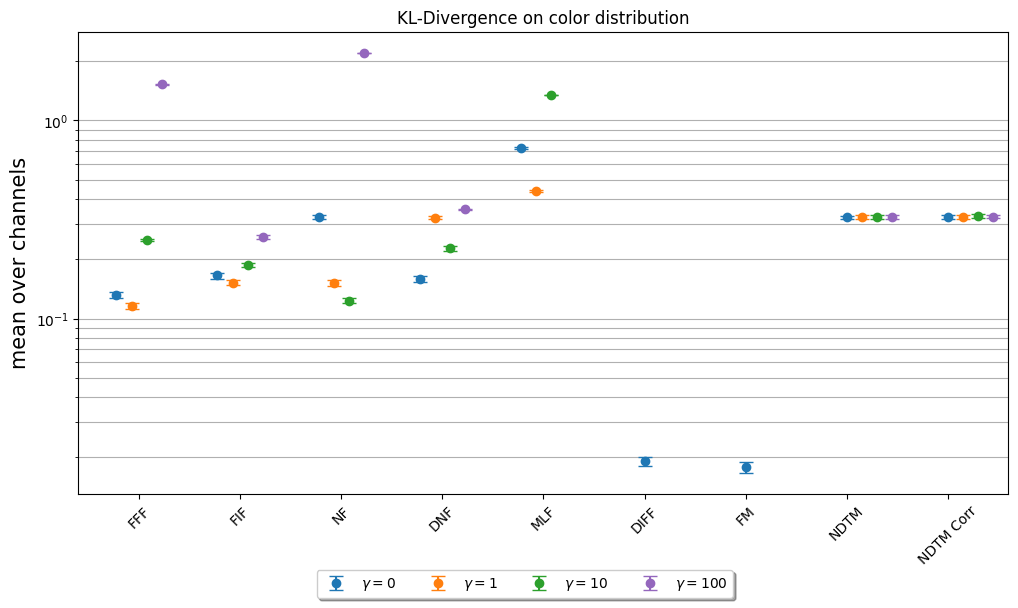

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
x_names = ["FFF", "FIF", "NF", "DNF", "MLF", "DIFF", "FM", "NDTM", "NDTM Corr"]

bpvs = {0: [],
        1: [],
        10: [],
        100: [],
       }
positions = {0: [],
             1: [],
             10: [],
             100: [],
            }
offsets = {0: -0.225,
           1: -0.075,
           10: 0.075,
           100: 0.225,
          }

x = list(range(len(x_names)))

for j, key in enumerate(model_names.keys()):
    for i, run in enumerate(model_names[key]):
        _, kl_stats, _, _, _ = load_model_stats(run)
        gamma = 0
        if run.endswith("_0"):
            gamma = 1
        if run.endswith("_1"):
            gamma = 10
        if run.endswith("_2"):
            gamma = 100
        kl_stats_mean = (np.mean([col_kl[0] for col_kl in kl_stats]), np.mean([col_kl[1] for col_kl in kl_stats]))
        bpvs[int(gamma)].append(kl_stats_mean)
        positions[int(gamma)].append(j + offsets[gamma])
        if j >= 5:
            positions[int(gamma)][-1] += 0.225
        
y_0 = [stats[0] for stats in bpvs[0]]
y_1 = [stats[0] for stats in bpvs[1]]
y_10 = [stats[0] for stats in bpvs[10]]
y_100 = [stats[0] for stats in bpvs[100]]
y_error_0 = [stats[1] for stats in bpvs[0]]
y_error_1 = [stats[1] for stats in bpvs[1]]
y_error_10 = [stats[1] for stats in bpvs[10]]
y_error_100 = [stats[1] for stats in bpvs[100]]
plt.errorbar(positions[0], y_0, y_error_0, fmt="o", capsize=5,label=r"$\gamma=0$")
plt.errorbar(positions[1], y_1, y_error_1, fmt="o", capsize=5,label=r"$\gamma=1$")
plt.errorbar(positions[10], y_10, y_error_10, fmt="o", capsize=5,label=r"$\gamma=10$")
plt.errorbar(positions[100], y_100, y_error_100, fmt="o", capsize=5,label=r"$\gamma=100$", c="tab:purple")
plt.xticks(x, x_names[:],rotation=45)
plt.grid(axis='y', which="both", ls="-")
plt.ylabel("mean over channels", fontsize=15)
plt.title("KL-Divergence on color distribution")
plt.yscale("log")
plt.xlim(-0.6,len(x_names) - 0.4)
#plt.ylim(0.01, 0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.15),
          ncol=4, fancybox=True, shadow=True)
plt.show()

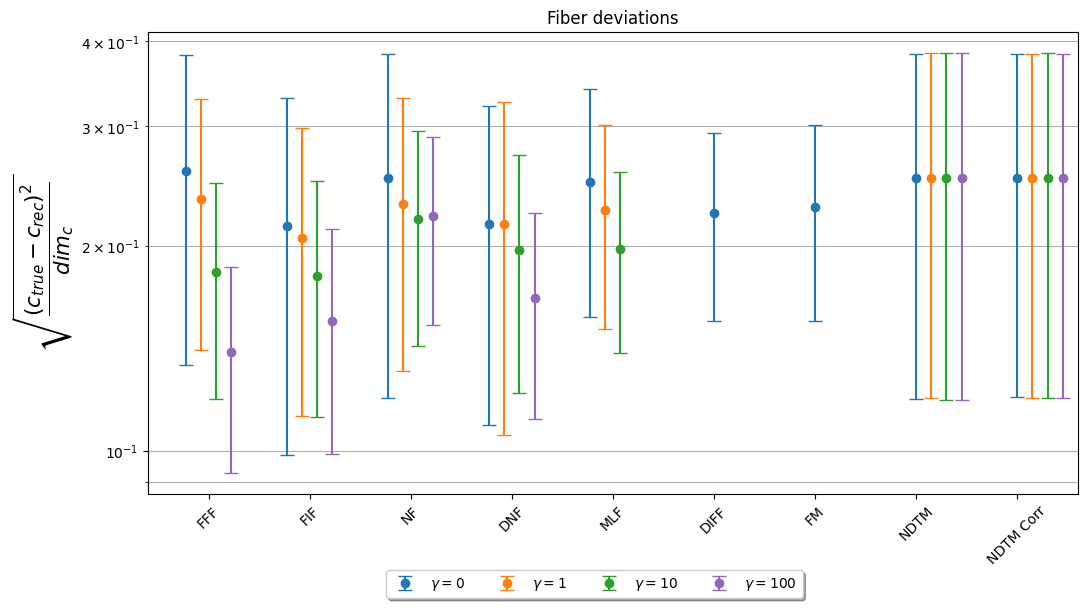

In [6]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
x_names = ["FFF", "FIF", "NF", "DNF", "MLF", "DIFF", "FM", "NDTM", "NDTM Corr"]

bpvs = {0: [],
        1: [],
        10: [],
        100: [],
       }
positions = {0: [],
             1: [],
             10: [],
             100: [],
            }
offsets = {0: -0.225,
           1: -0.075,
           10: 0.075,
           100: 0.225,
          }

x = list(range(len(x_names)))

for j, key in enumerate(model_names.keys()):
    for i, run in enumerate(model_names[key]):
        fiber_loss, _, _, _, _ = load_model_stats(run)
        gamma = 0
        if run.endswith("_0"):
            gamma = 1
        if run.endswith("_1"):
            gamma = 10
        if run.endswith("_2"):
            gamma = 100
        bpvs[int(gamma)].append(fiber_loss)
        positions[int(gamma)].append(j + offsets[gamma])
        if j >= 5:
            positions[int(gamma)][-1] += 0.225
        
y_0 = [stats[0] for stats in bpvs[0]]
y_1 = [stats[0] for stats in bpvs[1]]
y_10 = [stats[0] for stats in bpvs[10]]
y_100 = [stats[0] for stats in bpvs[100]]
y_error_0 = [stats[1] for stats in bpvs[0]]
y_error_1 = [stats[1] for stats in bpvs[1]]
y_error_10 = [stats[1] for stats in bpvs[10]]
y_error_100 = [stats[1] for stats in bpvs[100]]
plt.errorbar(positions[0], y_0, y_error_0, fmt="o", capsize=5,label=r"$\gamma=0$")
plt.errorbar(positions[1], y_1, y_error_1, fmt="o", capsize=5,label=r"$\gamma=1$")
plt.errorbar(positions[10], y_10, y_error_10, fmt="o", capsize=5,label=r"$\gamma=10$")
plt.errorbar(positions[100], y_100, y_error_100, fmt="o", capsize=5,label=r"$\gamma=100$", c="tab:purple")
plt.xticks(x, x_names[:],rotation=45)
plt.grid(axis='y', which="both", ls="-")
plt.ylabel(r"$\sqrt{\frac{(c_{true}-c_{rec})^2}{dim_c}}$", fontsize=22)
plt.title("Fiber deviations")
plt.yscale('log')
plt.xlim(-0.6,len(x_names) - 0.4)
#plt.ylim(0.01, 0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.15),
          ncol=4, fancybox=True, shadow=True)
plt.show()

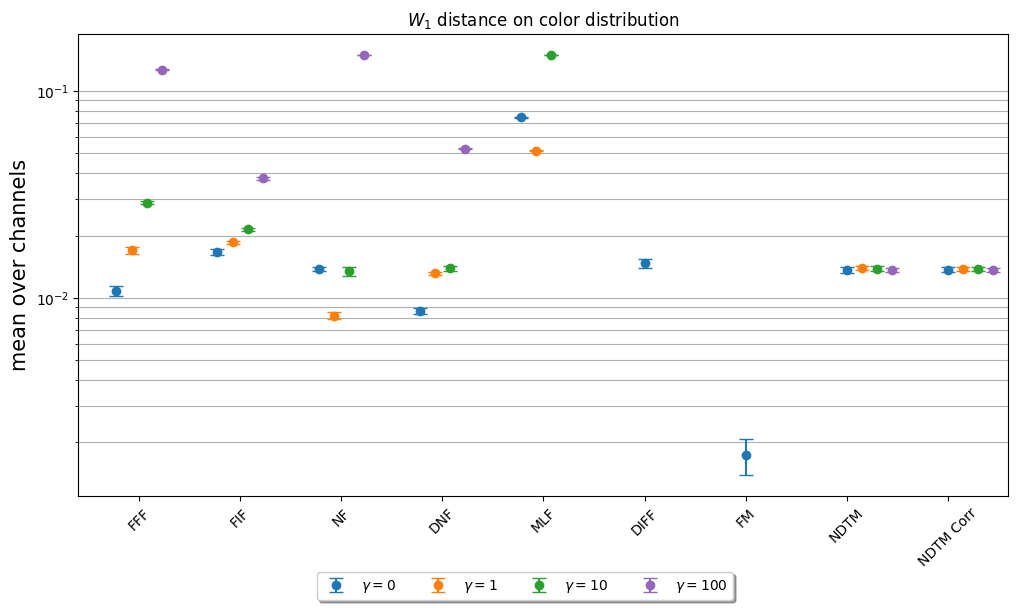

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
x_names = ["FFF", "FIF", "NF", "DNF", "MLF", "DIFF", "FM", "NDTM", "NDTM Corr"]

bpvs = {0: [],
        1: [],
        10: [],
        100: [],
       }
positions = {0: [],
             1: [],
             10: [],
             100: [],
            }
offsets = {0: -0.225,
           1: -0.075,
           10: 0.075,
           100: 0.225,
          }

x = list(range(len(x_names)))

for j, key in enumerate(model_names.keys()):
    for i, run in enumerate(model_names[key]):
        _, _, w1_stats, _, _ = load_model_stats(run)
        gamma = 0
        if run.endswith("_0"):
            gamma = 1
        if run.endswith("_1"):
            gamma = 10
        if run.endswith("_2"):
            gamma = 100
        w1_stats_mean = (np.mean([col_w1[0] for col_w1 in w1_stats]), np.mean([col_w1[1] for col_w1 in w1_stats]))
        bpvs[int(gamma)].append(w1_stats_mean)
        positions[int(gamma)].append(j + offsets[gamma])
        if j >= 5:
            positions[int(gamma)][-1] += 0.225
        
y_0 = [stats[0] for stats in bpvs[0]]
y_1 = [stats[0] for stats in bpvs[1]]
y_10 = [stats[0] for stats in bpvs[10]]
y_100 = [stats[0] for stats in bpvs[100]]
y_error_0 = [stats[1] for stats in bpvs[0]]
y_error_1 = [stats[1] for stats in bpvs[1]]
y_error_10 = [stats[1] for stats in bpvs[10]]
y_error_100 = [stats[1] for stats in bpvs[100]]
plt.errorbar(positions[0], y_0, y_error_0, fmt="o", capsize=5,label=r"$\gamma=0$")
plt.errorbar(positions[1], y_1, y_error_1, fmt="o", capsize=5,label=r"$\gamma=1$")
plt.errorbar(positions[10], y_10, y_error_10, fmt="o", capsize=5,label=r"$\gamma=10$")
plt.errorbar(positions[100], y_100, y_error_100, fmt="o", capsize=5,label=r"$\gamma=100$", c="tab:purple")
plt.xticks(x, x_names[:],rotation=45)
plt.grid(axis='y', which="both", ls="-")
plt.ylabel("mean over channels", fontsize=15)
plt.title(r"$W_1$ distance on color distribution")
plt.yscale("log")
plt.xlim(-0.6,len(x_names) - 0.4)
#plt.ylim(0.01, 0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.15),
          ncol=4, fancybox=True, shadow=True)
plt.show()

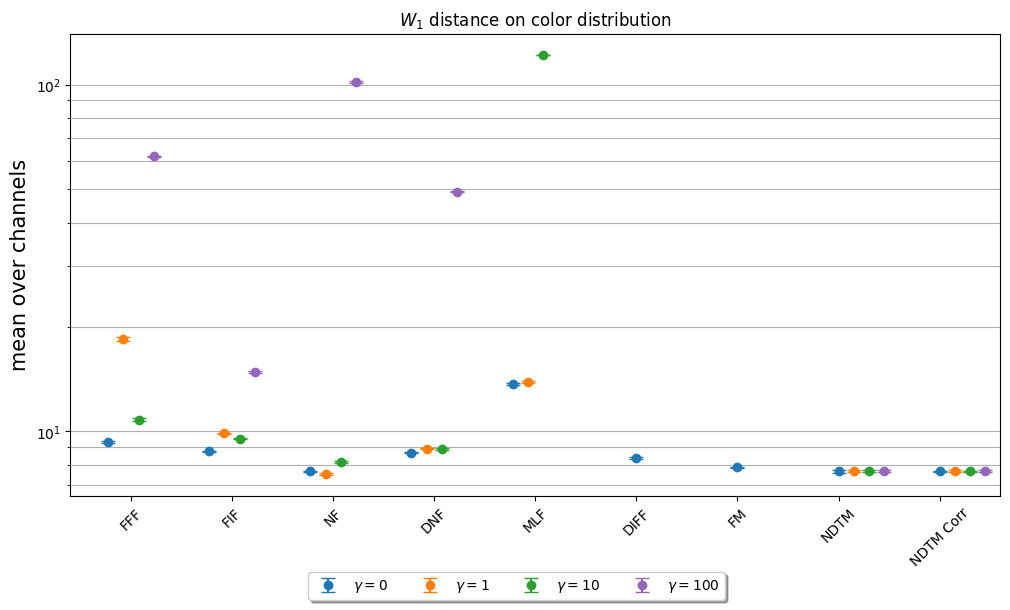

In [15]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
x_names = ["FFF", "FIF", "NF", "DNF", "MLF", "DIFF", "FM", "NDTM", "NDTM Corr"]

bpvs = {0: [],
        1: [],
        10: [],
        100: [],
       }
positions = {0: [],
             1: [],
             10: [],
             100: [],
            }
offsets = {0: -0.225,
           1: -0.075,
           10: 0.075,
           100: 0.225,
          }

x = list(range(len(x_names)))

for j, key in enumerate(model_names.keys()):
    for i, run in enumerate(model_names[key]):
        _, _, _, _, fid_stats = load_model_stats(run)
        gamma = 0
        if run.endswith("_0"):
            gamma = 1
        if run.endswith("_1"):
            gamma = 10
        if run.endswith("_2"):
            gamma = 100
        bpvs[int(gamma)].append(fid_stats)
        positions[int(gamma)].append(j + offsets[gamma])
        if j >= 5:
            positions[int(gamma)][-1] += 0.225
        
y_0 = [stats[0] for stats in bpvs[0]]
y_1 = [stats[0] for stats in bpvs[1]]
y_10 = [stats[0] for stats in bpvs[10]]
y_100 = [stats[0] for stats in bpvs[100]]
y_error_0 = [stats[1] for stats in bpvs[0]]
y_error_1 = [stats[1] for stats in bpvs[1]]
y_error_10 = [stats[1] for stats in bpvs[10]]
y_error_100 = [stats[1] for stats in bpvs[100]]
plt.errorbar(positions[0], y_0, y_error_0, fmt="o", capsize=5,label=r"$\gamma=0$")
plt.errorbar(positions[1], y_1, y_error_1, fmt="o", capsize=5,label=r"$\gamma=1$")
plt.errorbar(positions[10], y_10, y_error_10, fmt="o", capsize=5,label=r"$\gamma=10$")
plt.errorbar(positions[100], y_100, y_error_100, fmt="o", capsize=5,label=r"$\gamma=100$", c="tab:purple")
plt.xticks(x, x_names[:],rotation=45)
plt.grid(axis='y', which="both", ls="-")
plt.ylabel("mean over channels", fontsize=15)
plt.title(r"$W_1$ distance on color distribution")
plt.yscale("log")
plt.xlim(-0.6,len(x_names) - 0.4)
#plt.ylim(0.01, 0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.15),
          ncol=4, fancybox=True, shadow=True)
plt.show()

In [ ]:
from torch.distributions import Normal, Uniform, Laplace
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
import numpy as np
from scipy.special import kl_div, rel_entr

weights = torch.tensor([0.6, 0.35, 0.05, 0.6]).to(device)
centers = torch.tensor([0.7, 0.5, 0.1, -0.3]).to(device)
stddevs = torch.tensor([0.08, 0.015, 0.02, 0.08]).to(device)

def get_background_gmm(weights, centers, stddevs):
    mix = Categorical(weights)
    comp = Normal(centers, stddevs)
    gmm = MixtureSameFamily(mix, comp)
    return gmm

def Colorize(x_gray, c):
    c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_c = x_gray * ((c_image+0.5)%1 - c_image) + c_image
    return x_c

def Decolorize(x_colored):
    def detect_colors(x_data):
        background_colors = torch.mean(x_data[:,:,:,0],-1)
        return background_colors
    x_c = x_colored.reshape(-1,3,28,28)
    c = detect_colors(x_c)
    c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_dc = (x_c-c_image) / ((c_image+0.5)%1 - c_image)
    return x_dc.abs(), c


def normal(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma
def gaussian_mix_dense(x):
    return 0.6 * normal(x, 0.7, 0.08) + 0.35 * normal(x, 0.5, 0.015) + 0.05 * normal(x, 0.1, 0.02)

def compute_kl_w1_and_deviation(sample_list, n_bins=100):
    kls_r, kls_g, kls_b = [], [], []
    w1s_r, w1s_g, w1s_b = [], [], []
    dev = []
    for samples in sample_list:
        x_dc, colors = Decolorize(samples)
        max_pix = torch.max(x_dc.mean(1).reshape(-1,28*28), -1)[0].cpu()
        dev.append(torch.abs(max_pix - 1).mean().numpy())

        kls_c, w1s_c = [], []
        for c in range(3):
            H, bins = np.histogram(colors[:, c].cpu(), bins=n_bins, range=[0,1], density=True)
            bin_width = bins[1] - bins[0]
            mids = bins[:-1] + bin_width / 2

            # Discretized probabilities
            p = H * bin_width
            q = gaussian_mix_dense(mids) * bin_width
            p /= p.sum()
            q /= q.sum()

            # KL divergence
            kl_per_bin = rel_entr(p, q)
            kl_per_bin = kl_per_bin[~np.logical_or(np.isnan(kl_per_bin), np.isinf(kl_per_bin))]
            kl = np.sum(kl_per_bin)
            kls_c.append(kl)

            # Wasserstein-1 distance
            C_p = np.cumsum(p)
            C_q = np.cumsum(q)
            tv_per_bin = np.abs(C_p - C_q)
            tv_per_bin = tv_per_bin[~np.logical_or(np.isnan(tv_per_bin), np.isinf(tv_per_bin))]
            w1 = np.sum(tv_per_bin) * bin_width
            w1s_c.append(w1)

        kls_r.append(kls_c[0]); kls_g.append(kls_c[1]); kls_b.append(kls_c[2])
        w1s_r.append(w1s_c[0]); w1s_g.append(w1s_c[1]); w1s_b.append(w1s_c[2])

    # Aggregate statistics
    def summarize(values):
        mean = np.mean(values)
        std = np.std(values) / np.sqrt(len(values))
        return mean, std

    kl_means = [summarize(x) for x in [kls_r, kls_g, kls_b]]
    w1_means = [summarize(x) for x in [w1s_r, w1s_g, w1s_b]]
    dev_mean, dev_std = summarize(dev)

    return kl_means, w1_means, (dev_mean, dev_std)